In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv'
df = pd.read_csv(file_path)

In [3]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','neutral_score','day_of_week',]
df.drop(columns=columns_to_drop, inplace=True)

In [4]:
# Mapping dictionary for sentiment transformation
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Using map function to create a new column 'sentiment_c' with transformed values
df['sentiment_c'] = df['Sentiment_Classification'].map(sentiment_mapping)

# Create a new column 'helpful' based on the condition
df['helpful'] = (df['helpful_vote'] > 0).astype(int)

In [5]:
Emp_inf = df['helpful'].value_counts()

print(Emp_inf)


helpful
0    18608
1     3483
Name: count, dtype: int64


In [6]:
# Assuming df is your original dataframe
features = ['review_ext', 'sentiment_c', 'word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
            'image', 'ver_purch', '#nouns', '#adj', '#adv', 'subjective_score', 'FRE', 'product']
target = 'helpful'

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.20, random_state=0)
print('xtrain shape')
print(xtrain.shape)
print('xtest shape')
print(xtest.shape)

In [7]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming df is your original dataframe
features = ['review_ext', 'sentiment_c', 'word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
            'image', 'ver_purch', '#nouns', '#adj', '#adv', 'subjective_score', 'FRE', 'product']
target = 'helpful'

X = df[features]
y = df[target]

# Encode the 'product' column using one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
product_encoded = encoder.fit_transform(X[['product']])

# Convert the encoded columns to a DataFrame and drop the original 'product' column
product_encoded_df = pd.DataFrame(product_encoded, columns=encoder.get_feature_names_out(['product']))
X = X.drop(columns=['product']).reset_index(drop=True)
X = pd.concat([X, product_encoded_df], axis=1)

# Extract the minority class samples (helpful = 1)
X_minority = X[y == 1]
y_minority = y[y == 1]

# Calculate the number of samples to generate
n_samples_to_generate = 5000 - len(y_minority)

# Apply SMOTE to generate new samples for the minority class
sm = SMOTE(random_state=42, sampling_strategy={1: 4000})
X_res, y_res = sm.fit_resample(X, y)

# Extract the new minority samples generated by SMOTE
X_generated_minority = X_res[len(X):]
y_generated_minority = y_res[len(y):]

# Ensure the product distribution is maintained in the generated samples
generated_product_distribution = product_encoded_df[y == 1].mean()
generated_products = (generated_product_distribution * n_samples_to_generate).astype(int)

# Adjust the generated samples to match the product distribution
X_final_resampled = X.copy()
y_final_resampled = y.copy()

for product, count in zip(generated_product_distribution.index, generated_products):
    product_mask = X_generated_minority[product] == 1
    samples_to_add = X_generated_minority[product_mask].sample(count, replace=True)
    X_final_resampled = pd.concat([X_final_resampled, samples_to_add])
    y_final_resampled = pd.concat([y_final_resampled, pd.Series([1] * count)])

# Reset index to ensure correct alignment
X_final_resampled.reset_index(drop=True, inplace=True)
y_final_resampled.reset_index(drop=True, inplace=True)

# Print the shape of the resampled dataset
print('Resampled dataset shape {}'.format(Counter(y_final_resampled)))

# Checking the balance within each product
for product in encoder.categories_[0]:
    product_mask = X_final_resampled[f'product_{product}'] == 1
    print(f"Product: {product}")
    print(Counter(y_final_resampled[product_mask]))

Resampled dataset shape Counter({0: 18608, 1: 4998})
Product: Battery
Counter({0: 6234, 1: 1472})
Product: Filter
Counter({0: 4513, 1: 996})
Product: Gaming Mouse
Counter({0: 3503, 1: 742})
Product: Hair Brush
Counter({0: 3245, 1: 782})
Product: Toilet Paper
Counter({0: 1113, 1: 1006})


xtrain shape
(18086, 19)
xtest shape
(4522, 19)


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Define your numerical features
numerical_features = ['review_ext', 'sentiment_c', 'word_count', 'sent_count', 'sent_length', 
                      'title_length', 'elap_days', 'image', 'ver_purch', '#nouns', '#adj', 
                      '#adv', 'subjective_score', 'FRE']

# Define your preprocessor to scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features)  # Scale numerical features
    ]
)

# Scale the features (assuming xtrain and xtest are your train and test data)
xtrain_scaled = preprocessor.fit_transform(xtrain)
xtest_scaled = preprocessor.transform(xtest)

# Convert y_train and y_test to a 2D array
ytrain = ytrain.values.reshape(-1, 1)
ytest = ytest.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
ytrain_scaled = scaler.fit_transform(ytrain)
ytest_scaled = scaler.transform(ytest)


In [10]:
'Random Forest Classifier on resampled data'''

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfmodel = RandomForestClassifier()
rfmodel.fit(xtrain,ytrain)
print('model')
print(rfmodel)

ypredrf = rfmodel.predict(xtest)
print('confusion matrix')
print(metrics.confusion_matrix(ytest, ypredrf))
print('classification report')
print(metrics.classification_report(ytest, ypredrf))
print('Accuracy : %f' % (metrics.accuracy_score(ytest, ypredrf)))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, ypredrf)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


model
RandomForestClassifier()
confusion matrix
[[3625   92]
 [ 505  300]]
classification report
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      3717
           1       0.77      0.37      0.50       805

    accuracy                           0.87      4522
   macro avg       0.82      0.67      0.71      4522
weighted avg       0.86      0.87      0.85      4522

Accuracy : 0.867979
Area under the curve : 0.673960


In [11]:
'''Extreme Gradient Boost Algorithm on reduced dimensions data'''

from xgboost.sklearn import XGBClassifier

# Create the XGB classifier, xgb_model.
xgb_model = XGBClassifier()

# List the default parameters.
print(xgb_model.get_xgb_params())

# Train and evaluate.
xgb_model.fit(xtrain, ytrain, eval_metric=['error'], eval_set=[((xtrain, ytrain)),(xtest, ytest)])

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
[0]	validation_0-error:0.17666	validation_1-error:0.17802
[1]	validation_0-error:0.15266	validation_1-error:0.15812
[2]	validation_0-error:0.13812	validation_1-error:0.14971
[3]	validation_0-error:0.13159	validation_1-error:0.14197
[4]	validation_0-error:0.12711	va

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[22]	validation_0-error:0.09925	validation_1-error:0.12494
[23]	validation_0-error:0.09787	validation_1-error:0.12406
[24]	validation_0-error:0.09698	validation_1-error:0.12517
[25]	validation_0-error:0.09593	validation_1-error:0.12517
[26]	validation_0-error:0.09527	validation_1-error:0.12472
[27]	validation_0-error:0.09560	validation_1-error:0.12539
[28]	validation_0-error:0.09460	validation_1-error:0.12428
[29]	validation_0-error:0.09333	validation_1-error:0.12472
[30]	validation_0-error:0.09206	validation_1-error:0.12539
[31]	validation_0-error:0.09134	validation_1-error:0.12517
[32]	validation_0-error:0.09090	validation_1-error:0.12517
[33]	validation_0-error:0.08979	validation_1-error:0.12295
[34]	validation_0-error:0.08836	validation_1-error:0.12340
[35]	validation_0-error:0.08769	validation_1-error:0.12318
[36]	validation_0-error:0.08697	validation_1-error:0.12340
[37]	validation_0-error:0.08609	validation_1-error:0.12273
[38]	validation_0-error:0.08460	validation_1-error:0.121

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

y_pred = xgb_model.predict(xtest)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest, y_pred))
print('classification report')
print(metrics.classification_report(ytest, y_pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest, y_pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, y_pred)))

confusion matrix
[[3560  157]
 [ 426  379]]
classification report
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3717
           1       0.71      0.47      0.57       805

    accuracy                           0.87      4522
   macro avg       0.80      0.71      0.74      4522
weighted avg       0.86      0.87      0.86      4522

-----------------------------------------------------------------------------------------
Accuracy is :
0.8710747456877488
Area under the curve : 0.714285


## 2. Feature Importance with Shap Values

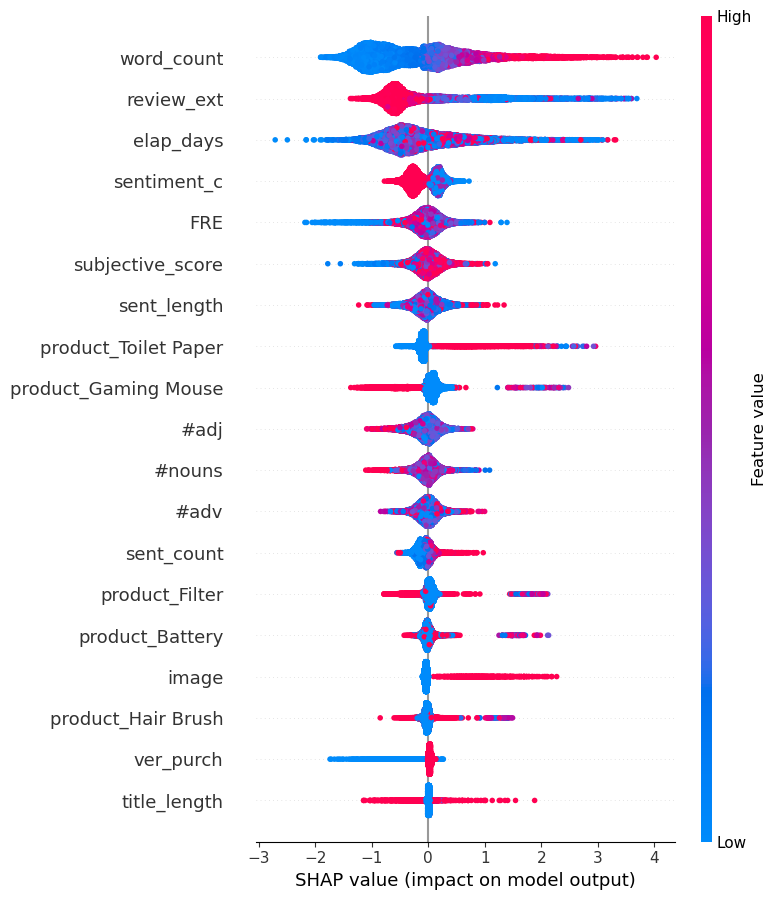

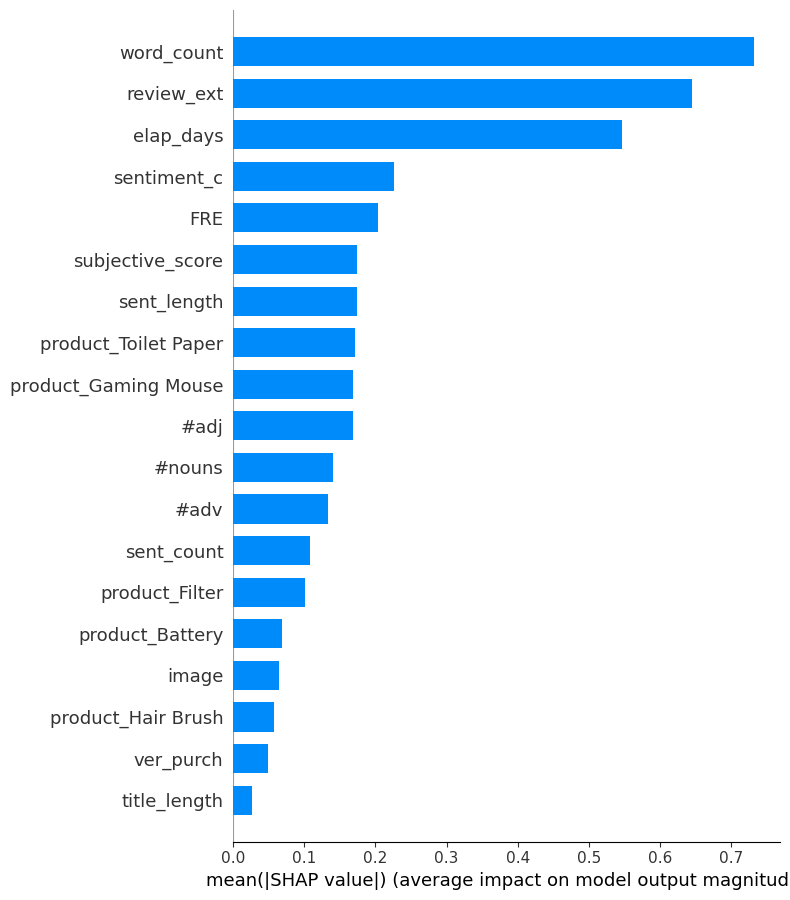

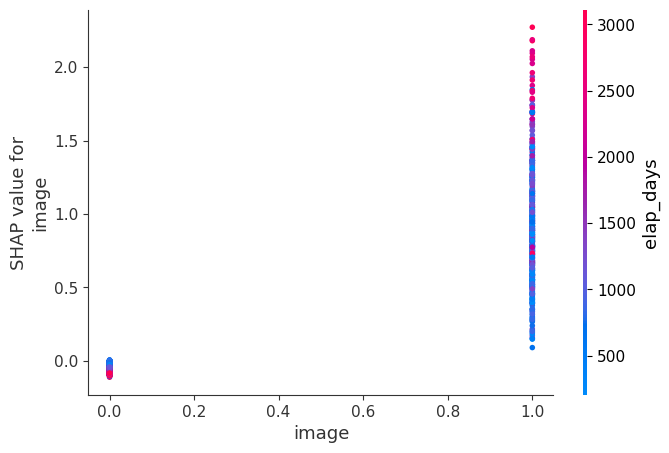

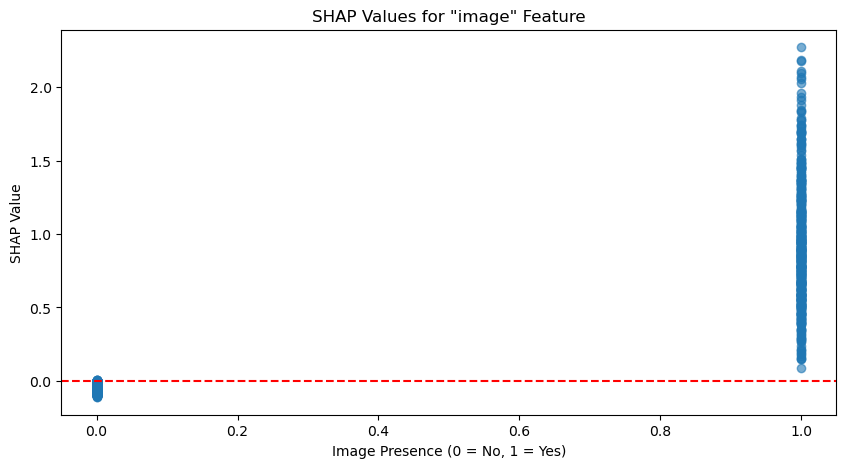

In [13]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(xtrain)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, xtrain)

# Create a beeswarm plot
shap.summary_plot(shap_values, xtrain, plot_type="bar", show=False)
plt.show()

# Plot specifically for the 'image' feature
shap.dependence_plot('image', shap_values, xtrain)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, xtrain.columns.get_loc('image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(xtrain['image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()
